In [1]:
# -*- coding: utf-8 -*-
import pandas as pd
from pandas._libs.tslibs import timestamps
from datetime import datetime
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import pymysql
from  sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from datetime import datetime
import joblib
from sklearn.metrics import mean_squared_error,confusion_matrix, accuracy_score
from mpl_toolkits.mplot3d import Axes3D
Axes3D = Axes3D  # pycharm auto import
#Import the Keras libraries and packages
import tensorflow as tf
from tensorflow import keras 
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense,Dropout
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())

In [2]:
mydb=pymysql.connect(host='localhost',port=int(3306),user='root',passwd='',db='sensor_data') 
#waterlevel range 1
query1 = "Select cast(timestamp as char) as Date, cast(thingName as char) as waterLevel, ROW_NUMBER() OVER (ORDER BY id) row_num , cast(value as char) as water_value  FROM sensor_data WHERE thingName BETWEEN 'NIVÅ019' AND 'NIVÅ023' AND data_type='waterLevelMmAdjustedRH2000' ;"
df1 = pd.read_sql(query1,mydb)
#print(df1)
#sea level
query2 = "Select cast(thingName as char) as seaLevel,ROW_NUMBER() OVER (ORDER BY id) row_num, cast(value as char) as sea_value FROM sensor_data WHERE thingName BETWEEN 'NIVÅ015' AND 'NIVÅ016' AND data_type='waterLevelMmAdjustedRH2000' ;"
df2 = pd.read_sql(query2,mydb)
#print(df2)
#ground water
query3 = "Select  cast(thingName as char) as groundLevel, ROW_NUMBER() OVER (ORDER BY id) row_num, cast(value as char) as ground_value,smhi_rain  FROM sensor_data WHERE data_type='waterLevel' ;"
df3 = pd.read_sql(query3,mydb)

In [3]:
#Separate dates for future plotting
df1["Date"] = pd.to_datetime(df1["Date"])
train_dates = df1["Date"] 

print(train_dates)
#print(train_dates.tail(15))#Check last few dates. 
 
df1_1=pd.DataFrame(df1[["row_num","waterLevel","water_value"]])
df2_2=pd.DataFrame(df2[["row_num","seaLevel","sea_value"]])
df3_3=pd.DataFrame(df3[["row_num","groundLevel","ground_value","smhi_rain"]])
#print reading result
print(df1_1)
print(df2_2)
print(df3_3)
# concatniting data
#dataframe=[df3_3,df2_2,df1_1]
#df1.merge(df2_2,how='left', left_on='Column1', right_on='ColumnA')
df=pd.merge(df3_3,df1_1, on='row_num')
df_last=pd.merge(df,df2_2, on='row_num')
print(df_last)

 # x, y with sklearn convert to nump.ndarray
df_last = df_last[["water_value","smhi_rain","sea_value","ground_value"]].to_numpy()# here we have 4 variables for multiple regression. 
#y = df_last[["water_value"]].to_numpy() 
#df_last=pd.merge(x,y, on="row_num")
    #print(x)
print(df_last)

0      2021-05-28 23:52:22
1      2021-05-28 22:56:52
2      2021-05-28 21:59:46
3      2021-05-28 20:50:16
4      2021-05-28 18:57:54
               ...        
4564   2021-08-04 04:56:58
4565   2021-08-04 03:59:46
4566   2021-08-04 02:54:02
4567   2021-08-04 02:00:38
4568   2021-08-04 01:00:39
Name: Date, Length: 4569, dtype: datetime64[ns]
      row_num waterLevel water_value
0           1    Nivå023        1281
1           2    Nivå023        1282
2           3    Nivå023        1282
3           4    Nivå023        1283
4           5    Nivå023        1284
...       ...        ...         ...
4564     4565    Nivå020       11673
4565     4566    Nivå020       11678
4566     4567    Nivå020       11678
4567     4568    Nivå020       11674
4568     4569    Nivå020       11698

[4569 rows x 3 columns]
      row_num seaLevel sea_value
0           1  Nivå016        79
1           2  Nivå016       103
2           3  Nivå016       111
3           4  Nivå016       134
4           5  Nivå01

In [4]:
# normalize the dataset
scaler = StandardScaler()
scaler=scaler.fit(df_last)
df_x=scaler.transform(df_last)
# splitting the data
#x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)
#print(x_train)

In [5]:
#As required for LSTM networks, we require to reshape an input data into n_samples x timesteps x n_features. 
#In this example, the n_features is 4. We will make timesteps = 15 (past days data used for training). 

#Empty lists to be populated using formatted training data
x_train = []
y_train = []

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 15  # Number of past days we want to use to predict the future.

#Reformat input data into a shape: (n_samples x timesteps x n_features)
#the df_x has a shape (3208, 4)
#3208 refers to the number of data points and 4 refers to the columns (multi-variables).
for i in range(n_past, len(df_x) - n_future +1):
    x_train.append(df_x[i - n_past:i, 0:df_x.shape[1]])
    y_train.append(df_x[i + n_future - 1:i + n_future, 0])

x_train,y_train = np.array(x_train), np.array(y_train)

print(x_train)
print(y_train)
print('x_train shape == {}.'.format(x_train.shape))
print('y_train shape == {}.'.format(y_train.shape))

[[[-0.83938507  1.21278972 -0.21220018 -0.47799776]
  [-0.83917429  1.21278972  0.02446945 -0.47799776]
  [-0.83917429  1.21278972  0.10335933 -0.47799776]
  ...
  [-0.84191441  1.21278972  0.14280426 -0.47799776]
  [-0.6905752   1.21278972  0.42878006 -0.47799776]
  [-0.6905752   1.21278972  0.09349809 -0.47799776]]

 [[-0.83917429  1.21278972  0.02446945 -0.47799776]
  [-0.83917429  1.21278972  0.10335933 -0.47799776]
  [-0.83896351  1.21278972  0.33016772 -0.47799776]
  ...
  [-0.6905752   1.21278972  0.42878006 -0.47799776]
  [-0.6905752   1.21278972  0.09349809 -0.47799776]
  [-0.69036443  1.21278972  0.38933513 -0.47799776]]

 [[-0.83917429  1.21278972  0.10335933 -0.47799776]
  [-0.83896351  1.21278972  0.33016772 -0.47799776]
  [-0.83875273  1.21278972  0.48794747 -0.47799776]
  ...
  [-0.6905752   1.21278972  0.09349809 -0.47799776]
  [-0.69036443  1.21278972  0.38933513 -0.47799776]
  [-0.69036443  1.21278972  0.22169414 -0.47799776]]

 ...

 [[ 1.34934243 -0.82454525  1.4346

In [6]:
# define the Autoencoder model

model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(x_train.shape[1], x_train.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(y_train.shape[1]))

model.compile(optimizer='adam', loss='mse',metrics=['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 15, 64)            17664     
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 30,113
Trainable params: 30,113
Non-trainable params: 0
_________________________________________________________________


Epoch 1/5
181/181 [==============================] - 61s 20ms/step - loss: 0.6150 - mean_squared_error: 0.6150 - mean_absolute_error: 0.6235 - mean_absolute_percentage_error: 64.8843 - val_loss: 0.1907 - val_mean_squared_error: 0.1907 - val_mean_absolute_error: 0.2911 - val_mean_absolute_percentage_error: 36.4030
Epoch 2/5
181/181 [==============================] - 2s 11ms/step - loss: 0.2118 - mean_squared_error: 0.2118 - mean_absolute_error: 0.2913 - mean_absolute_percentage_error: 32.8449 - val_loss: 0.1468 - val_mean_squared_error: 0.1468 - val_mean_absolute_error: 0.2069 - val_mean_absolute_percentage_error: 23.1970
Epoch 3/5
181/181 [==============================] - 2s 12ms/step - loss: 0.1651 - mean_squared_error: 0.1651 - mean_absolute_error: 0.2370 - mean_absolute_percentage_error: 27.0346 - val_loss: 0.1195 - val_mean_squared_error: 0.1195 - val_mean_absolute_error: 0.1621 - val_mean_absolute_percentage_error: 17.5709
Epoch 4/5
181/181 [==============================] - 2s 1

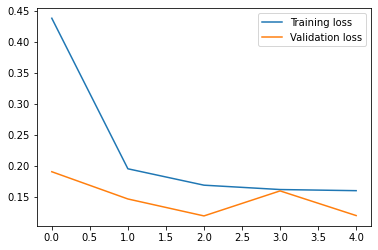

In [7]:
# fit the model
history = model.fit(x_train, y_train, epochs=5, batch_size=16, validation_split=0.1, verbose=1)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

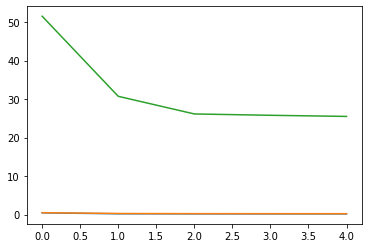

In [8]:
# plot metrics
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['mean_absolute_percentage_error'])

plt.show()

        Date  Water_Level_last
0 2021-09-12      10912.457031
1 2021-09-13      10951.300781
2 2021-09-14      10963.931641
3 2021-09-15      10972.953125
4 2021-09-16      10976.852539
5 2021-09-17      10980.711914
6 2021-09-18      10985.781250
                    Date water_value
4562 2021-08-04 06:57:22       11674
4563 2021-08-04 05:56:21       11678
4564 2021-08-04 04:56:58       11673
4565 2021-08-04 03:59:46       11678
4566 2021-08-04 02:54:02       11678
4567 2021-08-04 02:00:38       11674
4568 2021-08-04 01:00:39       11698


C:\Users\alha1207\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Date', ylabel='Water_Level_last'>

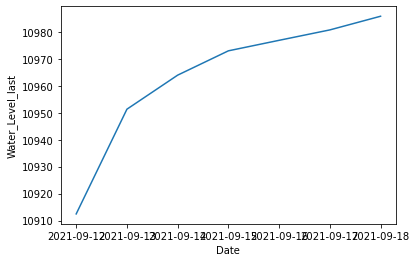

In [9]:
n_future=7
#n_past = 16
#n_days_for_prediction=15
#print(train_dates)
#train_dates=pd.to_datetime(pd.Series(df1["Date"]))
#print(train_dates)
#list(train_dates)[-1]
forecast_period_dates = pd.date_range(start=datetime.now(), periods=n_future, freq='1D').tolist()
#print(forecast_period_dates)
#predict the next 7 days
#print(x_train)
forecast = model.predict(x_train[-n_future:])
#print(forecast)
forecast_copies =np.repeat(forecast, df_last.shape[1],axis=-1)
y_pred_future = scaler.inverse_transform(forecast_copies)[:,0]
#print(forecast_copies)
#print(y_pred_future)
# Convert timestamp to date
forecast_dates = []
for time_i in forecast_period_dates:
    forecast_dates.append(time_i.date())
df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'Water_Level_last':y_pred_future})
df_forecast["Date"]=pd.to_datetime(df_forecast["Date"])
print(df_forecast)

original = df1[["Date","water_value"]]
original = original.tail(7)
print(original)
#original["Date"]=df1["Date"]
#original = original.loc[original["Date"] >= '2021-8-4']
#print(original)
#sns.set(rc={'figure.figsize':(8,8)})
#sns.lineplot(original["Date"], original["water_value"])
sns.lineplot(df_forecast["Date"], df_forecast["Water_Level_last"])

In [13]:
#test values
predicted_waterLevel = df_forecast["Water_Level_last"] 
print("Water Level for next 7 days :\n",df_forecast) 
for i in predicted_waterLevel:
    if(i > 1200): 
         print("Will flood soon") 
    else:
         print("Water level is OK") 
dir='C:\\Users\\alha1207\\ANN\\output\\'
filename ='ANN_model_6.sav' 
joblib.dump(predicted_waterLevel, dir + filename)

Water Level for next 7 days :
         Date  Water_Level_last
0 2021-09-12      10912.457031
1 2021-09-13      10951.300781
2 2021-09-14      10963.931641
3 2021-09-15      10972.953125
4 2021-09-16      10976.852539
5 2021-09-17      10980.711914
6 2021-09-18      10985.781250
Will flood soon
Will flood soon
Will flood soon
Will flood soon
Will flood soon
Will flood soon
Will flood soon


['C:\\Users\\alha1207\\ANN\\output\\ANN_model_6.sav']

In [11]:
## database cloding 
mydb.close() #close the connection
print("Database closed!")

Database closed!
